1 and 2 parameter bifurcation diagrams for vdp-thal

# Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
import response as rp

import vdp_thal

import importlib
import lib

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps,get_es_min,get_es_max)

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)

import lib.rhs

importlib.reload(sys.modules['lib.util'])
importlib.reload(sys.modules['lib.rhs'])
from lib.util import (get_phase, freq_est)
#from lib.rhs import (_redu)
from lib.rhs import _redu_c2, _full, _full_mono_rhs

_redu = _redu_c2

from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os
from matplotlib.patches import Circle

from scipy.optimize import root,bisect
from copy import deepcopy

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

# Dicts

In [2]:
kw_sim = {'rtol':1e-7,'atol':1e-7,'method':'LSODA'}

In [3]:
pd_thal = {'gL':0.05,'gna':3,'gk':5,
           'gt':5,'eL':-70,'ena':50,
           'ek':-90,'et':0,'esyn':-100,
           'c':1,'alpha':3,'beta':2,
           'sigmat':0.8,'vt':-20,'del':0,
           'ib':8.2,'om':1,'om_fix':1}

pd_vdp = {'mu':.04,'sigmat':0.1,'vt':1,
          'alpha':3,'beta':2,'esyn':-2,
          'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws_thal = {'var_names':['v','h','r','w'],
            'pardict':pd_thal,
            'rhs':vdp_thal.rhs_thal,
            'coupling':vdp_thal.coupling_thal,
            'init':np.array([-.64,0.71,0.25,0,6]),
            'TN':10000,
            'trunc_order':1,
            'z_forward':False,
            'i_forward':False,
            'i_bad_dx':[False,True,False,False,False,False],
            'max_iter':20,
            'rtol':1e-12,
            'atol':1e-12,
            'rel_tol':1e-9,
            'save_fig':False,
            'lc_prominence':.05}

kws_vdp = {'var_names':['v','h','w'],
               'pardict':pd_vdp,
               'rhs':vdp_thal.rhs_vdp,
               'coupling':vdp_thal.coupling_vdp,
               'init':np.array([.32,0.128,0.54,20]),
               'TN':10000,
               'trunc_order':1,
               'z_forward':False,
               'i_forward':False,
               'i_bad_dx':[False,True,False,False,False,False],
               'max_iter':20,
               'rtol':1e-12,
               'atol':1e-12,
               'rel_tol':1e-9,
               'save_fig':False,
               'lc_prominence':.05}

In [5]:
het_coeffs = [1,20]

# Defs

In [6]:
mname1 = 'vdp_thal23_b={}'
mname2 = 'vdp_thal23_b2={}'

mname_list = ['vdp_thal11_b'+str(i)+'={}' for i in range(5)]

In [7]:
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':10000,
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [8]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.concatenate([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=False,
                 return_full=False,**kwargs):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = path_loc+'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = path_loc+'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]
        #dat2[:,3] = solr_o3.y[0]
        #dat2[:,4] = solr_o4.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

# Initialize

In [9]:
system1 = rsp(idx=0,model_name='vdp_thal0',**kws_thal)
system2 = rsp(idx=1,model_name='vdp_thal1',**kws_vdp)

mkdir ./data/vdp_thal0/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0084015231173136
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024653498269982924
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/vdp_thal1/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000999958313446
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.04000799998305697
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 2:3

In [10]:
# parameters to be fixed for 1 par diagrams
nm_tup = (2,3)

In [11]:
a23 = nm.nmCoupling(system1,system2,
                    #recompute_list=['k_gwt1','p_gwt1'],
                    #recompute_list=['p_data_gwt0','p_data_gwt1','h_data_gwt0','h_data_gwt1'],
                    #recompute_list=recompute_list,
                    _n=('om0',nm_tup[0]),_m=('om1',nm_tup[1]),
                    het_coeffs=het_coeffs,
                    NH=1024)

Initializing 23 Coupling...
pfactor 29
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H vdp_thal0, order=0...
* Loading H vdp_thal1, order=0...
* Loading H vdp_thal0, order=1...
* Loading H vdp_thal1, order=1...


In [12]:
# define aliases as a template
a = a23

nm_val = str(nm_tup[0])+str(nm_tup[1])

In [13]:
etup = (0,.11,100)
dtup = (-.115,-.105)

## Phase line

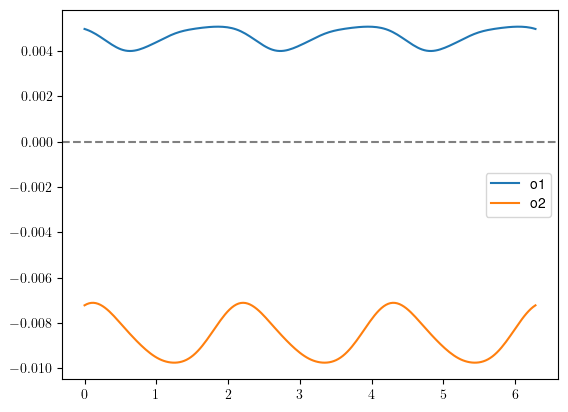

In [14]:
a = a23
e = .1
b = -.113
x_temp2 = np.linspace(0,2*np.pi,200)

rhs1 = _redu(0,x_temp2,a,e,b,miter=1)
rhs2 = _redu(0,x_temp2,a,e,b)

fig,axs = plt.subplots()
axs.plot(x_temp2,rhs1,label='o1')
axs.plot(x_temp2,rhs2,label='o2')
axs.axhline(0,0,2*np.pi,ls='--',color='gray')
axs.legend()

## Plot 1par eps

In [15]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.106,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [16]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.108,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [17]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.109,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

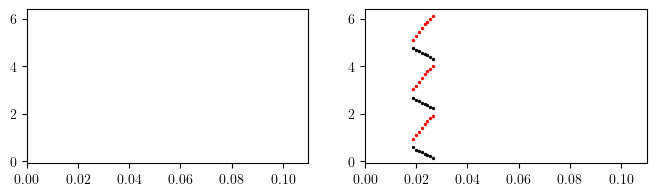

In [18]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.11,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

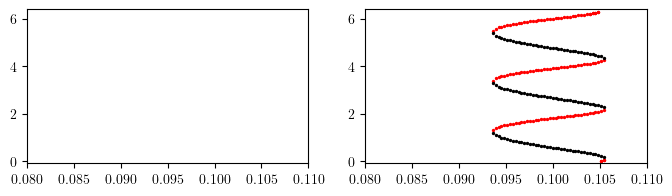

In [19]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.14,eps_tup=(.08,.11,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

## Plot 1par del

In [20]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,eps=e1,del_tup=dtup,rhs=_redu_c2)
# add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

## EPS VARY

In [21]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_vdp_thal/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_gwt_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_gwt_'+nm_val+'_b={}_u.txt'

In [22]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=-.106

#### Branches eps stable

In [23]:
b=-.106
kw_b['recompute'] = False
kw_b['b'] = b

In [24]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.005,eps_final=0.0,deps=-.001),
            dict(phi0=0,eps_init=0.004,eps_final=0.1,deps=.001),
            #dict(phi0=0,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [25]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [26]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [27]:
kw_b['recompute'] = False
kw_b['b'] = b

In [28]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.005,eps_final=0,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 1.2
phase_diffs_u_init=1.2_nm=23_b=-0.106_ei=0.005_ef=0_de=-1.txt
phase_diffs_u_pt_init=1.2_nm=23_b=-0.106_ei=0.005_ef=0_de=-1.txt


In [29]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=1.2,eps_init=0.005,eps_final=0,deps=-.0002),
            dict(phi0=5.3,eps_init=0.004,eps_final=0.015,deps=.0002),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [30]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 1.2
phase_diffs_u_init=1.2_nm=23_b=-0.106_ei=0.005_ef=0_de=-0.0002.txt
phase_diffs_u_pt_init=1.2_nm=23_b=-0.106_ei=0.005_ef=0_de=-0.0002.txt
phi init 5.3
phase_diffs_u_init=5.3_nm=23_b=-0.106_ei=0.004_ef=0.015_de=0.0002.txt
phase_diffs_u_pt_init=5.3_nm=23_b=-0.106_ei=0.004_ef=0.015_de=0.0002.txt


In [31]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

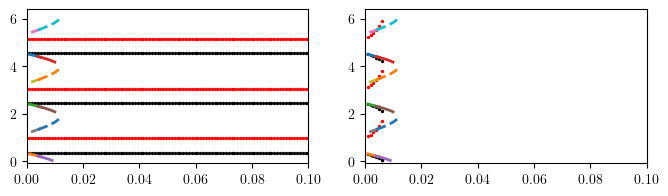

In [32]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0,.1,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [33]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.011299999999999987 3.8662370913535877
phi init 3.8662370913535877
Y [-0.10548454  0.24598218  0.09882858  0.38702074  1.77637918  0.88926959  0.59961018  6.28276606]
mkdir ./data/vdp_thal11_b0=-0.106/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999332714877898
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = 3.861621430950836e-08
es_min,phi0 0.010799999999999987 3.8662370913535877
phi init 3.8662370913535877
Y [-0.1302692   0.14296714  0.09827861  0.49868835  1.90667314  0.553991    0.59912099  6.28280196]
mkdir ./data/vdp_thal11_b1=-0.106/
* Loading LC data...
self.T 6.283185307179586 omfix 0.9999389873176723
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00015950979456486972
es_min,phi0 0.010299999999999986 3.8662370913535877
phi init 3.8662370913535877
Y [-0.12008961  0.1597192   0.09839205  0.48165819  1.95465052  0.36174753  0.59856915  6.28284044

In [34]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.107

#### Branches eps stable

In [35]:
b=-.107
kw_b['recompute'] = False
kw_b['b'] = b

In [36]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
            dict(phi0=.5,eps_init=0.015,eps_final=0.0,deps=-.0002),
            dict(phi0=0,eps_init=0.014,eps_final=0.1,deps=.001)
           ]

In [37]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0.5
phi init 0


In [38]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [39]:
kw_b['recompute'] = False
kw_b['b'] = b

In [40]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.015,eps_final=0.,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.107_ei=0.015_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.107_ei=0.015_ef=0.0_de=-1.txt


In [41]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.015,eps_final=0,deps=-.0002),
            dict(phi0=5.5,eps_init=0.014,eps_final=0.1,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [42]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.107_ei=0.015_ef=0_de=-0.0002.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.107_ei=0.015_ef=0_de=-0.0002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.107_ei=0.014_ef=0.1_de=0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.107_ei=0.014_ef=0.1_de=0.001.txt


In [43]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

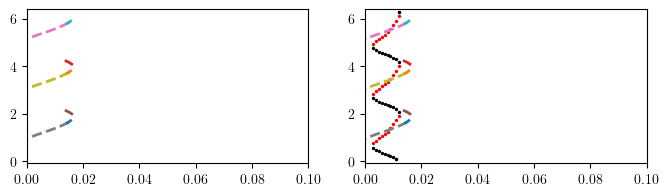

In [44]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0,.1,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

### b=-.108

#### Branches eps stable

In [45]:
b=-.108
kw_b['recompute'] = False
kw_b['b'] = b

In [46]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.018,eps_final=0.001,deps=-.002),
            dict(phi0=0,eps_init=0.017,eps_final=0.05,deps=.001),
            #dict(phi0=0,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [47]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [48]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [49]:
kw_b['recompute'] = False
kw_b['b'] = b

In [50]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.02,eps_final=0.0,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.108_ei=0.02_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.108_ei=0.02_ef=0.0_de=-1.txt


In [51]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.,eps_init=0.015,eps_final=0.001,deps=-.002),
            dict(phi0=5.5,eps_init=0.014,eps_final=0.1,deps=.002),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [52]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.0
phase_diffs_u_init=5.0_nm=23_b=-0.108_ei=0.015_ef=0.001_de=-0.002.txt
phase_diffs_u_pt_init=5.0_nm=23_b=-0.108_ei=0.015_ef=0.001_de=-0.002.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.108_ei=0.014_ef=0.1_de=0.002.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.108_ei=0.014_ef=0.1_de=0.002.txt


In [53]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

In [54]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=b,eps_tup=(0,.1,100),rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# for i in range(2):
#     draw_quick_plot_f(axs[i],data_bs_list,a)
#     draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [55]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+.0001+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# print(m1b.eigenvalues)

In [56]:
# fig,axs = plt.subplots(figsize=(3,3))
# axs.scatter(m1.eigenvalues.real,m1.eigenvalues.imag)
# axs.scatter(m1b.eigenvalues.real,m1b.eigenvalues.imag,color='red')
# circ = Circle((0, 0), radius=1, edgecolor='k', facecolor='None'); axs.add_patch(circ)
# axs.set_xlim(.95,1.01)

In [57]:
# b_vals_full.append(b)

# es = get_smallest_eps(data_bs_list)
# eu = get_smallest_eps(data_bu_list)

# e_vals_full.append(np.min([es,eu]))

# es = get_largest_eps(data_bs_list)
# eu = get_largest_eps(data_bu_list)

# e_hi_full.append(np.max([es,eu]))

### b=-.1085

#### Branches eps stable

In [58]:
b=-.1085
kw_b['recompute'] = False
kw_b['b'] = b

In [59]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.02,eps_final=0.001,deps=-.002),
            dict(phi0=0,eps_init=0.019,eps_final=0.05,deps=.002),
            #dict(phi0=0,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [60]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [61]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [62]:
kw_b['recompute'] = False
kw_b['b'] = b

In [63]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.015,eps_final=0,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.1085_ei=0.015_ef=0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.1085_ei=0.015_ef=0_de=-1.txt


In [64]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.015,eps_final=0.001,deps=-.001),
            dict(phi0=5.5,eps_init=0.014,eps_final=0.04,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [65]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.1085_ei=0.015_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.1085_ei=0.015_ef=0.001_de=-0.001.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.1085_ei=0.014_ef=0.04_de=0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.1085_ei=0.014_ef=0.04_de=0.001.txt


In [66]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

In [67]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=b,eps_tup=(0,.1,100),rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# for i in range(2):
#     draw_quick_plot_f(axs[i],data_bs_list,a)
#     draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [68]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+.0001+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [69]:
# fig,axs = plt.subplots(figsize=(3,3))
# axs.scatter(m1.eigenvalues.real,m1.eigenvalues.imag)
# axs.scatter(m1b.eigenvalues.real,m1b.eigenvalues.imag,color='red')
# circ = Circle((0, 0), radius=1, edgecolor='k', facecolor='None'); axs.add_patch(circ)
# axs.set_xlim(.95,1.01)

In [70]:
# b_vals_full.append(b)

# es = get_smallest_eps(data_bs_list)
# eu = get_smallest_eps(data_bu_list)

# e_vals_full.append(np.min([es,eu]))

# es = get_largest_eps(data_bs_list)
# eu = get_largest_eps(data_bu_list)

# e_hi_full.append(np.max([es,eu]))

### b=-.109

#### Branches eps stable

In [71]:
b=-.109
kw_b['recompute'] = False
kw_b['b'] = b

In [72]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.02,eps_final=0.001,deps=-.002),
            dict(phi0=0,eps_init=0.019,eps_final=0.05,deps=.002),
            #dict(phi0=0,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [73]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [74]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [75]:
kw_b['recompute'] = False
kw_b['b'] = b

In [76]:
# get an initial condition for an unstable branch
dat,Yinit = follow_phase_diffs_u(**dict(phi0=3,eps_init=0.02,eps_final=0.0,deps=-1),return_point=True,**kw_b)
# dat,Yinit = follow_phase_diffs_u(**dict(phi0=1.2,eps_init=0.019,eps_final=0.018,deps=-.01),return_point=True,**kw_b)

phi init 3
phase_diffs_u_init=3_nm=23_b=-0.109_ei=0.02_ef=0.0_de=-1.txt
phase_diffs_u_pt_init=3_nm=23_b=-0.109_ei=0.02_ef=0.0_de=-1.txt


In [77]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=3,eps_init=0.02,eps_final=0.0,deps=-.002),
            dict(phi0=3,eps_init=0.019,eps_final=0.05,deps=.002),
            # dict(phi0=3.5,eps_init=0.049,eps_final=0.05,deps=.002),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [78]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3
phase_diffs_u_init=3_nm=23_b=-0.109_ei=0.02_ef=0.0_de=-0.002.txt
phase_diffs_u_pt_init=3_nm=23_b=-0.109_ei=0.02_ef=0.0_de=-0.002.txt
phi init 3
phase_diffs_u_init=3_nm=23_b=-0.109_ei=0.019_ef=0.05_de=0.002.txt
phase_diffs_u_pt_init=3_nm=23_b=-0.109_ei=0.019_ef=0.05_de=0.002.txt


In [79]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

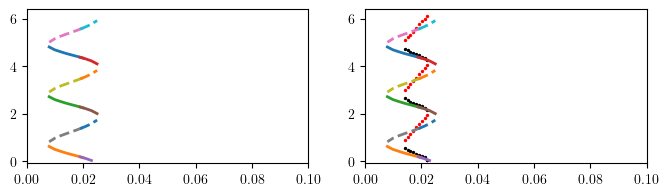

In [80]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0,.1,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [81]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.00810000000000001 2.7105073835250044
phi init 2.7105073835250044
Y [-0.10451914  0.23537493  0.09878212  0.39922979 -1.19367625  1.60225211  0.06096326  6.28342895]
mkdir ./data/vdp_thal11_b0=-0.109/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000387674223552
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00011440123398616256
es_min,phi0 0.00860000000000001 2.7105073835250044
phi init 2.7105073835250044
Y [-0.10482877  0.24283865  0.09878295  0.39058862 -1.26681288  1.54511179  0.05558237  6.28341857]
mkdir ./data/vdp_thal11_b1=-0.109/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000371175205305
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00016737226157914788
es_min,phi0 0.00910000000000001 2.7105073835250044
phi init 2.7105073835250044
Y [-0.10455538  0.23659239  0.09873223  0.39780668 -1.35249558  1.47099082  0.04965355  6.28340882]

In [82]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.11

#### Branches eps stable

In [83]:
b=-.11
kw_b['recompute'] = False
kw_b['b'] = b

In [84]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.022,eps_final=0.001,deps=-.002),
            dict(phi0=0,eps_init=0.021,eps_final=0.1,deps=.002)]

In [85]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [86]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [87]:
kw_b['recompute'] = False
kw_b['b'] = b

In [88]:
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.4,eps_init=0.02,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 5.4
phase_diffs_u_init=5.4_nm=23_b=-0.11_ei=0.02_ef=0_de=-1.txt
phase_diffs_u_pt_init=5.4_nm=23_b=-0.11_ei=0.02_ef=0_de=-1.txt


In [89]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.02,eps_final=0.001,deps=-.001),
            dict(phi0=5.5,eps_init=0.019,eps_final=0.05,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [90]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.11_ei=0.02_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.11_ei=0.02_ef=0.001_de=-0.001.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.11_ei=0.019_ef=0.05_de=0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.11_ei=0.019_ef=0.05_de=0.001.txt


In [91]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

In [92]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=b,eps_tup=(0,.04,100),rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# for i in range(2):
#     draw_quick_plot_f(axs[i],data_bs_list,a)
#     draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [93]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+.0001+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

#### Monodromys max

In [94]:
# # get min eps
# es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_max_temp = []
# for i in range(5):
#     ee = es_max-.0001-0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_max_temp.append(ee)

# eigenvalues_max_all.append(eigenvalues_temp)
# e_vals_mono_max.append(es_max_temp)
# #m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [95]:
# b_vals_full.append(b)

# es = get_smallest_eps(data_bs_list)
# eu = get_smallest_eps(data_bu_list)

# e_vals_full.append(np.min([es,eu]))

# es = get_largest_eps(data_bs_list)
# eu = get_largest_eps(data_bu_list)

# e_hi_full.append(np.max([es,eu]))

### b=-.12

#### Branches eps stable

In [96]:
b=-.12
kw_b['recompute'] = False
kw_b['b'] = b

In [97]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0,eps_init=0.055,eps_final=0.001,deps=-.002),
            dict(phi0=0,eps_init=0.054,eps_final=0.1,deps=.002)]

In [98]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0
phi init 0


In [99]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [100]:
kw_b['recompute'] = False
kw_b['b'] = b

In [101]:
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.055,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.12_ei=0.055_ef=0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.12_ei=0.055_ef=0_de=-1.txt


In [102]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.055,eps_final=0.001,deps=-.001),
            dict(phi0=5.5,eps_init=0.054,eps_final=0.1,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [103]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.12_ei=0.055_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.12_ei=0.055_ef=0.001_de=-0.001.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.12_ei=0.054_ef=0.1_de=0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.12_ei=0.054_ef=0.1_de=0.001.txt


In [104]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

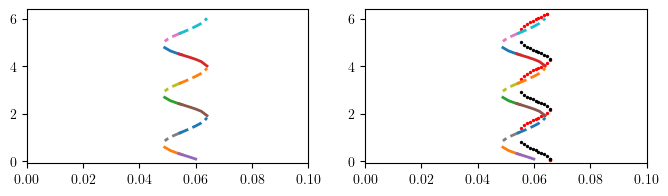

In [105]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(.0,.1,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [106]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0491 2.6811963142911677
phi init 2.6811963142911677
Y [-0.10366685  0.22878062  0.09778191  0.40760326  1.26274711 -1.51846612  0.32124038  6.28459065]
mkdir ./data/vdp_thal11_b0=-0.12/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0002236613413527
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0009632101628537308
es_min,phi0 0.0496 2.6811963142911677
phi init 2.6811963142911677
Y [-0.10389502  0.22827484  0.09773703  0.40822617  1.34210999 -1.44779802  0.38225833  6.28446095]
mkdir ./data/vdp_thal11_b1=-0.12/
* Loading LC data...
self.T 6.283185307179586 omfix 0.999977311662661
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0012196300330934555
es_min,phi0 0.0501 2.6811963142911677
phi init 2.6811963142911677
Y [-0.10411865  0.22738136  0.09769909  0.40928478  1.40612651 -1.38477512  0.42454726  6.28434229]
mkdir ./data/vdp_thal11_b2=-0.12/
* Loading

#### Monodromys max

In [107]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0639 1.9130653688027603
phi init 1.9130653688027603
Y [-0.10768311  0.23123637  0.09778977  0.40384999  1.92998441  0.32698631  0.59837908  6.28092965]
mkdir ./data/vdp_thal11_b0=-0.12/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0002236613413527
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0009632101628537308
es_min,phi0 0.0634 1.9130653688027603
phi init 1.9130653688027603
Y [-0.10762038  0.24031526  0.09776957  0.39351859  1.9549531   0.11669363  0.59722567  6.28110404]
mkdir ./data/vdp_thal11_b1=-0.12/
* Loading LC data...
self.T 6.283185307179586 omfix 0.999977311662661
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0012196300330934555
es_min,phi0 0.0629 1.9130653688027603
phi init 1.9130653688027603
Y [-1.07428168e-01  2.38781367e-01  9.77263435e-02  3.95420597e-01  1.95872548e+00 -6.91080984e-05  5.96263740e-01  6.28126697e+00]
mkdir ./dat

In [108]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.14

#### Branches eps stable

In [109]:
b=-.14
kw_b['recompute'] = False
kw_b['b'] = b

In [110]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0.5,eps_init=0.095,eps_final=0.001,deps=-.001),
            dict(phi0=0.5,eps_init=0.094,eps_final=0.1,deps=.001)]

In [111]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0.5
phi init 0.5


In [112]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [113]:
kw_b['recompute'] = False
kw_b['b'] = b

In [114]:
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.095,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.14_ei=0.095_ef=0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.14_ei=0.095_ef=0_de=-1.txt


In [115]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.095,eps_final=0.001,deps=-.001),
            dict(phi0=5.5,eps_init=0.094,eps_final=0.15,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [116]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.14_ei=0.095_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.14_ei=0.095_ef=0.001_de=-0.001.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.14_ei=0.094_ef=0.15_de=0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.14_ei=0.094_ef=0.15_de=0.001.txt


In [117]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

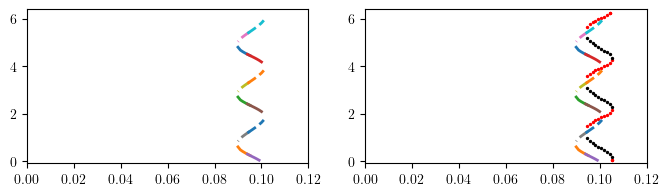

In [118]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0.0,.12,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [119]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0901 2.6971917328815453
phi init 2.6971917328815453
Y [-0.10298883  0.23055457  0.09702369  0.40607732  1.21415667 -1.52465594  0.28483696  6.28592151]
mkdir ./data/vdp_thal11_b0=-0.14/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0002865791821143
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0029023399911698206
es_min,phi0 0.0906 2.6971917328815453
phi init 2.6971917328815453
Y [-0.10365212  0.2242376   0.09691569  0.41329353  1.3310074  -1.42057019  0.38042028  6.28560194]
mkdir ./data/vdp_thal11_b1=-0.14/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0002982611113542
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0031263588662913985
es_min,phi0 0.0911 2.6971917328815453
phi init 2.6971917328815453
Y [-0.1040872   0.22533486  0.09686335  0.41216095  1.402918   -1.34717316  0.42889672  6.2853177 ]
mkdir ./data/vdp_thal11_b2=-0.14/
* Loadin

#### Monodromys max

In [120]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.1009 3.8187359363762745
phi init 3.8187359363762745
Y [-0.10933809  0.24190597  0.09725026  0.39169476  1.93387058  0.00752391  0.59618923  6.28024005]
mkdir ./data/vdp_thal11_b0=-0.14/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0002865791821143
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0029023399911698206
es_min,phi0 0.1004 3.8187359363762745
phi init 3.8187359363762745
Y [-0.10904378  0.24056276  0.09716727  0.39348363  1.92959754 -0.12042326  0.59469048  6.28055025]
mkdir ./data/vdp_thal11_b1=-0.14/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0002982611113542
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0031263588662913985
es_min,phi0 0.0999 3.8187359363762745
phi init 3.8187359363762745
Y [-0.1047988   0.22559913  0.09584892  0.40900335 -1.91408471 -0.01278875  0.00895638  6.2808447 ]
mkdir ./data/vdp_thal11_b2=-0.14/
* Loadin

In [121]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.16

#### Branches eps stable

In [122]:
b=-.16
kw_b['recompute'] = False
kw_b['b'] = b

In [123]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0.5,eps_init=0.11,eps_final=0.001,deps=-.001),
            dict(phi0=0.5,eps_init=0.109,eps_final=0.2,deps=.001)]

In [124]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0.5
phi init 0.5


In [125]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

In [126]:
data_bs_list

[array([[1.10000000e-01, 3.14291266e+00, 3.14291266e+00, 3.14291266e+00, 4.65906117e+00, 4.59208904e-01, 2.56293346e+00],
        [1.09000000e-01, 3.14341266e+00, 3.14341266e+00, 3.14341266e+00, 4.78724592e+00, 5.90860080e-01, 2.68885311e+00],
        [1.08000000e-01,            nan,            nan,            nan,            nan,            nan,            nan],
        [1.07000000e-01,            nan,            nan,            nan,            nan,            nan,            nan],
        [1.06000000e-01,            nan,            nan,            nan,            nan,            nan,            nan],
        [1.05000000e-01,            nan,            nan,            nan,            nan,            nan,            nan],
        [1.04000000e-01,            nan,            nan,            nan,            nan,            nan,            nan],
        [1.03000000e-01,            nan,            nan,            nan,            nan,            nan,            nan],
        [1.02000000e-01,

#### Branches eps unstable

In [127]:
kw_b['recompute'] = False
kw_b['b'] = b

In [128]:
dat,Yinit = follow_phase_diffs_u(**dict(phi0=5.5,eps_init=0.109,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.16_ei=0.109_ef=0_de=-1.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.16_ei=0.109_ef=0_de=-1.txt


In [129]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=5.5,eps_init=0.11,eps_final=0.001,deps=-.001),
            dict(phi0=5.5,eps_init=0.109,eps_final=0.15,deps=.001),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [130]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.16_ei=0.11_ef=0.001_de=-0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.16_ei=0.11_ef=0.001_de=-0.001.txt
phi init 5.5
phase_diffs_u_init=5.5_nm=23_b=-0.16_ei=0.109_ef=0.15_de=0.001.txt
phase_diffs_u_pt_init=5.5_nm=23_b=-0.16_ei=0.109_ef=0.15_de=0.001.txt


In [131]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

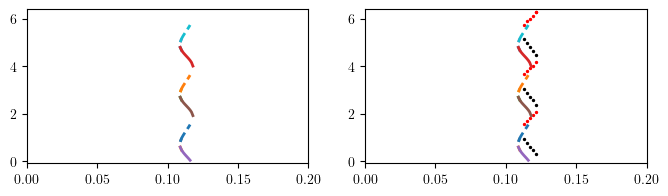

In [132]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0.0,.2,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [133]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.1091 2.688853112940752
phi init 2.688853112940752
Y [-0.10673004  0.2309432   0.09653734  0.40135986 -1.21708852  1.47417788  0.05264936  6.28666933]
mkdir ./data/vdp_thal11_b0=-0.16/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000012692045668
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0009229871915414547
es_min,phi0 0.1096 2.688853112940752
phi init 2.688853112940752
Y [-0.10661745  0.22055193  0.09621129  0.41345408 -1.38458771  1.31335248  0.04122125  6.28616039]
mkdir ./data/vdp_thal11_b1=-0.16/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0004734932894597
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0030018514827680346
es_min,phi0 0.1101 2.688853112940752
phi init 2.688853112940752
Y [-0.10404607  0.23942948  0.09659532  0.39647456  1.37759791 -1.35413996  0.41552231  6.28572338]
mkdir ./data/vdp_thal11_b2=-0.16/
* Loading LC d

#### Monodromys max

In [134]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.1179 1.9143533028149076
phi init 1.9143533028149076
Y [-1.04601515e-01  2.20125961e-01  9.55559183e-02  4.15336691e-01 -1.84855975e+00 -4.69610532e-01  5.50891379e-03  6.27951545e+00]
mkdir ./data/vdp_thal11_b0=-0.16/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000012692045668
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0009229871915414547
es_min,phi0 0.1174 1.9143533028149076
phi init 1.9143533028149076
Y [-0.10479584  0.22060952  0.09548711  0.41460518 -1.88652643 -0.24098528  0.00699573  6.28000876]
mkdir ./data/vdp_thal11_b1=-0.16/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0004734932894597
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0030018514827680346
es_min,phi0 0.1169 1.9143533028149076
phi init 1.9143533028149076
Y [-0.10961402  0.24144616  0.09694015  0.39264098  1.9101314  -0.20763955  0.59318968  6.28045782]
mkdir ./da

In [135]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.2

#### Branches eps stable

In [136]:
b=-.2
kw_b['recompute'] = False
kw_b['b'] = b

In [137]:
dat,Yinit = follow_phase_diffs(**dict(phi0=2.5,eps_init=0.125,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 2.5


In [138]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2.5,eps_init=0.125,eps_final=0.1,deps=-.0001),
            dict(phi0=2.5,eps_init=0.124,eps_final=0.14,deps=.0001)]

In [139]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2.5
phi init 2.5


In [140]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [141]:
kw_b['recompute'] = False
kw_b['b'] = b

In [142]:
dat,Yinit = follow_phase_diffs_u(**dict(phi0=6,eps_init=0.125,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 6
phase_diffs_u_init=6_nm=23_b=-0.2_ei=0.125_ef=0_de=-1.txt
phase_diffs_u_pt_init=6_nm=23_b=-0.2_ei=0.125_ef=0_de=-1.txt


In [143]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=6,eps_init=0.125,eps_final=0.1,deps=-.0005),
            dict(phi0=6,eps_init=0.124,eps_final=0.15,deps=.0005),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [144]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 6
phase_diffs_u_init=6_nm=23_b=-0.2_ei=0.125_ef=0.1_de=-0.0005.txt
phase_diffs_u_pt_init=6_nm=23_b=-0.2_ei=0.125_ef=0.1_de=-0.0005.txt
phi init 6
phase_diffs_u_init=6_nm=23_b=-0.2_ei=0.124_ef=0.15_de=0.0005.txt
phase_diffs_u_pt_init=6_nm=23_b=-0.2_ei=0.124_ef=0.15_de=0.0005.txt


In [145]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

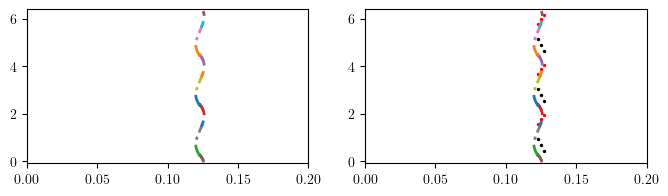

In [146]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0.0,.2,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [147]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.12019999999999986 0.6309767476147812
phi init 0.6309767476147812
Y [-0.10219235  0.23641639  0.09668182  0.3997391   1.10718232 -1.5832553   0.18987875  6.28719959]
mkdir ./data/vdp_thal11_b0=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006316211038786
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.019221365797551973+0j)
es_min,phi0 0.12069999999999986 0.6309767476147812
phi init 0.6309767476147812
Y [-0.10343744  0.23635699  0.09647118  0.40004855  1.32020036 -1.40172604  0.37685812  6.2863193 ]
mkdir ./data/vdp_thal11_b1=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0008018498325497
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.02100051926631268+0j)
es_min,phi0 0.12119999999999986 0.6309767476147812
phi init 0.6309767476147812
Y [-0.10462235  0.24046743  0.09639483  0.39555608  1.43673492 -1.2769641   0.45330924  6.28559961

#### Monodromys max

In [148]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.12580000000000008 6.174316253570669
phi init 6.174316253570669
Y [-1.04467658e-01  2.29805732e-01  9.54238436e-02  4.04188872e-01 -1.85556885e+00 -4.08750021e-01  5.84434629e-03  6.27940035e+00]
mkdir ./data/vdp_thal11_b0=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006316211038786
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.019221365797551973+0j)
es_min,phi0 0.12530000000000008 6.174316253570669
phi init 6.174316253570669
Y [-0.1047781   0.22766699  0.09531099  0.4063541  -1.8894047  -0.1112027   0.00796779  6.28019475]
mkdir ./data/vdp_thal11_b1=-0.2/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0008018498325497
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.02100051926631268+0j)
es_min,phi0 0.12480000000000008 6.174316253570669
phi init 6.174316253570669
Y [-0.10506756  0.2230452   0.09523975  0.41144609 -1.88794602  0.077133

In [149]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-.25

#### Branches eps stable

In [150]:
b=-.25
kw_b['recompute'] = False
kw_b['b'] = b

In [151]:
dat,Yinit = follow_phase_diffs(**dict(phi0=2.4,eps_init=0.12,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 2.4


In [152]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0.001,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=0.,eps_init=0.12,eps_final=0.09,deps=-.0001),
            dict(phi0=0.,eps_init=0.119,eps_final=0.14,deps=.0001)]

In [153]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 0.0
phi init 0.0


In [154]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

In [155]:
data_bs_list

[array([[0.12      , 3.14011265, 3.14011265, ..., 4.15497414, 6.2349624 , 2.0661817 ],
        [0.1199    , 3.14021265, 3.14021265, ..., 4.17945273, 6.25837431, 2.09052672],
        [0.1198    , 3.14041265, 3.14041265, ..., 4.20199522, 6.27998409, 2.11280209],
        ...,
        [0.0903    ,        nan,        nan, ...,        nan,        nan,        nan],
        [0.0902    ,        nan,        nan, ...,        nan,        nan,        nan],
        [0.0901    ,        nan,        nan, ...,        nan,        nan,        nan]]),
 array([[0.119     , 3.14121265, 3.14121265, ..., 4.34894355, 0.1392174 , 2.25748215],
        [0.1191    , 3.14111265, 3.14111265, ..., 4.3324794 , 0.12261923, 2.24115145],
        [0.1192    , 3.14101265, 3.14101265, ..., 4.31521405, 0.10602   , 2.22401956],
        ...,
        [0.1398    ,        nan,        nan, ...,        nan,        nan,        nan],
        [0.1399    ,        nan,        nan, ...,        nan,        nan,        nan],
        [0.14  

#### Branches eps unstable

In [156]:
kw_b['recompute'] = False
kw_b['b'] = b

In [157]:
dat,Yinit = follow_phase_diffs_u(**dict(phi0=6,eps_init=0.12,eps_final=0,deps=-1),return_point=True,**kw_b)

phi init 6
phase_diffs_u_init=6_nm=23_b=-0.25_ei=0.12_ef=0_de=-1.txt
phase_diffs_u_pt_init=6_nm=23_b=-0.25_ei=0.12_ef=0_de=-1.txt


In [158]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=6,eps_init=0.12,eps_final=0.1,deps=-.0005),
            dict(phi0=6,eps_init=0.119,eps_final=0.13,deps=.0005),
            #dict(phi0=3,eps_init=0.049,eps_final=0.1,deps=.005)
           ]

In [159]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 6
phase_diffs_u_init=6_nm=23_b=-0.25_ei=0.12_ef=0.1_de=-0.0005.txt
phase_diffs_u_pt_init=6_nm=23_b=-0.25_ei=0.12_ef=0.1_de=-0.0005.txt
phi init 6
phase_diffs_u_init=6_nm=23_b=-0.25_ei=0.119_ef=0.13_de=0.0005.txt
phase_diffs_u_pt_init=6_nm=23_b=-0.25_ei=0.119_ef=0.13_de=0.0005.txt


In [160]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

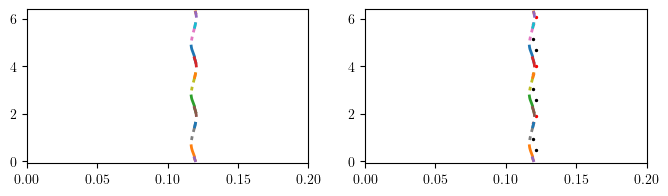

In [161]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0.0,.2,100),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [162]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+.0001+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.1168999999999999 2.742647562829821
phi init 2.742647562829821
Y [-0.1068891   0.22458934  0.09636059  0.4085152  -1.24722614  1.43956371  0.05001283  6.28689182]
mkdir ./data/vdp_thal11_b0=-0.25/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006904770108147
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.016589298677058526+0j)
es_min,phi0 0.11739999999999991 2.742647562829821
phi init 2.742647562829821
Y [-0.10445273  0.24180917  0.09646789  0.39392272  1.41234603 -1.3088619   0.43847888  6.28565863]
mkdir ./data/vdp_thal11_b1=-0.25/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0009396949144547
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.018125384296484262+0j)
es_min,phi0 0.11789999999999991 2.742647562829821
phi init 2.742647562829821
Y [-0.10596876  0.22669361  0.09635243  0.41122439  1.59182897 -1.07550312  0.5234732   6.2846164 ]
mk

#### Monodromys max

In [163]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-.0001-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.12030000000000003 1.9187559551943902
phi init 1.9187559551943902
Y [-1.04520500e-01  2.27585025e-01  9.55028631e-02  4.06743180e-01 -1.86966824e+00 -3.53727962e-01  6.21299447e-03  6.27963688e+00]
mkdir ./data/vdp_thal11_b0=-0.25/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0006904770108147
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.016589298677058526+0j)
es_min,phi0 0.11980000000000003 1.9187559551943902
phi init 1.9187559551943902
Y [-0.10946735  0.22881604  0.09677396  0.40746706  1.89668177 -0.2781979   0.59175586  6.28079351]
mkdir ./data/vdp_thal11_b1=-0.25/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0009396949144547
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = (-0.018125384296484262+0j)
es_min,phi0 0.11930000000000003 1.9187559551943902
phi init 1.9187559551943902
Y [-0.10872378  0.24263687  0.09663807  0.39207054  1.83030111 

In [164]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [165]:
twopar_neg = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_23_o2_neg_fixed.dat')
twopar_neg2 = np.loadtxt('../v2_bifdat_2par/redu/vdp_thal_23_o2_neg2_fixed.dat')

(-0.25, -0.1)

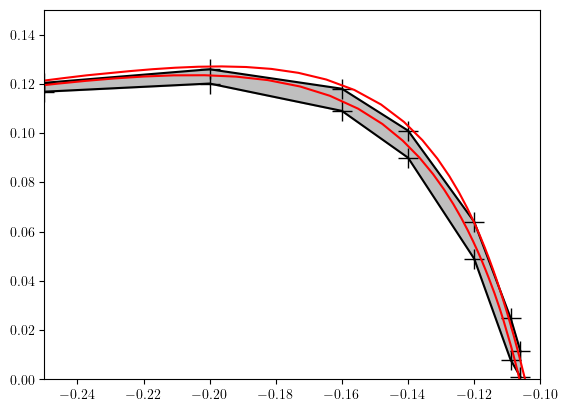

In [166]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.5)
axs.plot(b_vals_full,e_vals_full,marker='+',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='+',color='k',markersize=15)

# axs.scatter(twopar_neg[:,1],twopar_neg[:,0],color='r')
axs.plot(twopar_neg[:,1],twopar_neg[:,0],color='r')
axs.plot(twopar_neg2[:,1],twopar_neg2[:,0],color='r')

axs.set_ylim(0,.15)
axs.set_xlim(-.25,-.1)

In [167]:
fname_lo = '../v2_bifdat_2par/full/vdp_thal_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/vdp_thal_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

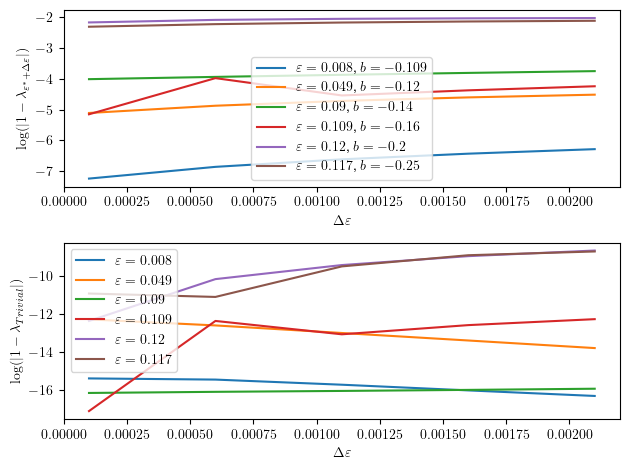

In [168]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(0.0001,0.0001+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

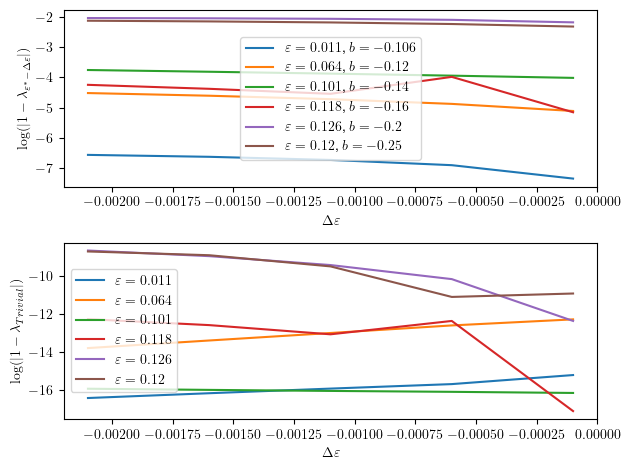

In [169]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_max_{}{}.png'.format(a._n[1],a._m[1]))